<a href="https://colab.research.google.com/github/mitsukacke2285/drug_discovery_repo/blob/main/Ligand_preparation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Ligand preparation

# Installation of dependencies

Please install the following packages:
* `PDBFixer`
* `Biopython`
* `MDAnalysis`
* `RDKit`
* `OpenMM` (and `OpenMMForceFields`)
* `OpenBabel`
* `Scrubber` (package: "`molscrub`")
* `py3Dmol`

In [ ]:
!pip install rdkit openmm mdanalysis molscrub py3dmol biopython
!pip install pdbfixer

In [ ]:
# Run this cell if pdbfixer could not be installed on colab
!pip install git+https://github.com/openmm/pdbfixer.git

  Cloning https://github.com/openmm/pdbfixer.git to c:\users\pham.congdat\appdata\local\temp\pip-req-build-xan3u693
  Resolved https://github.com/openmm/pdbfixer.git to commit 0f701349b1d0b7c91d2ca0db78359274d0793400
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'


  Running command git clone --filter=blob:none --quiet https://github.com/openmm/pdbfixer.git 'C:\Users\pham.congdat\AppData\Local\Temp\pip-req-build-xan3u693'


If running on colab, upload the following file:

In [ ]:
# If using google colab please upload the following files: test1.csv and {pdb_id}_A.pdb
from google.colab import files

# Upload a {pdb_id}.pdb file from local PC to your Colab VM
files.upload("molecular_docking/protein_files")

Saving test1.csv to molecular_docking/protein_files/test1.csv


{'molecular_docking/protein_files/test1.csv': b'SMILES\r\nBrC1=CC(N/N=C/C2=CNN=N2)=CC=N1\r\nC1(/C=N/NC2=CC=NC=C2)=CNN=N1\r\nBrC1=CC(C(NCC2=CNN=N2)=O)=CC=N1\r\nFC(C1=CC(N/N=C/C2=CNN=N2)=CC=N1)(F)F\r\nCC(C)C1=CC(N/N=C/C2=CNN=N2)=CC=N1\r\nO=C(C1=CC=NC=C1)NCC2=CNN=N2\r\nO=C(C1=CC=NC(C(F)(F)F)=C1)NCC2=CNN=N2\r\nO=C(C1=CC=NC(C(C)C)=C1)NCC2=CNN=N2\r\n'}

In [ ]:
# Upload a test1.csv file from local PC to your Colab VM
files.upload("molecular_docking/ligand_structures")

Saving test1.csv to molecular_docking/ligand_structures/test1.csv


{'molecular_docking/ligand_structures/test1.csv': b'SMILES\r\nBrC1=CC(N/N=C/C2=CNN=N2)=CC=N1\r\nC1(/C=N/NC2=CC=NC=C2)=CNN=N1\r\nBrC1=CC(C(NCC2=CNN=N2)=O)=CC=N1\r\nFC(C1=CC(N/N=C/C2=CNN=N2)=CC=N1)(F)F\r\nCC(C)C1=CC(N/N=C/C2=CNN=N2)=CC=N1\r\nO=C(C1=CC=NC=C1)NCC2=CNN=N2\r\nO=C(C1=CC=NC(C(F)(F)F)=C1)NCC2=CNN=N2\r\nO=C(C1=CC=NC(C(C)C)=C1)NCC2=CNN=N2\r\n'}

## Localization of co-crystalized ligand

In [ ]:
## Download PDB file ##

import os
import requests

pdb_id = input("Enter PDB code: ") # The Protein ID we're looking at

# Start by making a directory for us to work in and stage our intermediate files
protein_directory = "molecular_docking/protein_files"
protein_filename = f"{pdb_id}_A.pdb"
protein_filepath = os.path.join(protein_directory, protein_filename)

# Actually make the directory, the exist_ok flag lets the command execute even if the folder already exists. It does NOT overwrite existing data.
os.makedirs(protein_directory, exist_ok=True)

Enter PDB code:  1XTJ


In [ ]:
print(protein_filepath)

molecular_docking/protein_files\1XTJ_A.pdb


## Building Atomistic Ligand Model

In [ ]:
# Determine residues nearby the ligand with MDAnalysis
import MDAnalysis as mda

# Load the original PDB
u = mda.Universe(f"{protein_directory}/{pdb_id}_A.pdb")

# Select atoms using the MDAnalysis selection language
ligand_select = "segid A and record_type HETATM and not resname HOH"
ligand = u.select_atoms(ligand_select)

# Find and residues within a certain distance from the ligand
active_site = u.select_atoms(f"around 3.5 group ligand and segid A",
                             periodic=False,
                             ligand=ligand)  # Uses generic select_name=object as kwargs
print(active_site.residues.resids)
print(ligand.residues.resids)

[ 65  67  72  92  93  94  95  96 162 165 196 197 323 633]
[501 550 500]


In [ ]:
# Select ligand bound in PDB structure
import numpy as np

# This works well enough for single bound ligand, but is not general for more complicated or non-standard PDB codes
ligands = u.select_atoms("not protein and not water")
i = -1 # index
ligand_residue_names = ligands.residues.resnames

# Loop through all ligands present
for lig in ligand_residue_names:
  i = i+1
  print(i, lig)

0 MG
1 ADP
2 ACY


In [ ]:
# Select the index of your ligand of interest
ligand_id = np.unique(ligand_residue_names)[int(input('Enter index of ligand of interest: '))]
print(ligand_id)

Enter index of ligand of interest:  1


ADP


In [ ]:
# Download the ideal ligand from the RCSB, i.e. the co-crystallized ligand extracted from the PDB structure and stored as a separate sdf file
ligand_directory = "molecular_docking/ligand_structures"
os.makedirs(ligand_directory, exist_ok=True)

ideal_ligand_filename = f"{ligand_id}_ideal.sdf"
print(f"Downloading ligand {ligand_id}...")
ligand_url = f"https://files.rcsb.org/ligands/download/{ideal_ligand_filename}"
ligand_request = requests.get(ligand_url)
ligand_request.raise_for_status() # Check for errors

ideal_filepath = f"{ligand_directory}/{ideal_ligand_filename}"

with open(ideal_filepath, "w") as f:
    f.write(ligand_request.text)
print(f"Saved ligand to {ideal_filepath}")

Saved ligand to molecular_docking/ligand_structures/ADP_ideal.sdf


In [ ]:
# Display raw PDB file
from IPython.display import display, HTML

def render_text(text_blob):
  # Helper function for displaying text in Jupyter Notebooks in a scrollable object
  html = f"""
      <div style="height:400px; overflow:auto;">
          <pre>{text_blob}</pre>
      </div>
      """
  display(HTML(html))

render_text(ligand_request.text)

In [ ]:
# Split the ligand out into its own PDB file from the experimental one

# Use only Chain A since this is a dimer and our target site for docking
single_pose_ligand = ligand.select_atoms("segid A")
single_pose_ligand.write(f"{ligand_directory}/{ligand_id}_fromPDB.pdb")

C:\Users\pham.congdat\AppData\Local\anaconda3\Lib\site-packages\MDAnalysis\coordinates\PDB.py:777: UserWarning: Unit cell dimensions not found. CRYST1 record set to unitary values.
  warnings.warn("Unit cell dimensions not found. "
C:\Users\pham.congdat\AppData\Local\anaconda3\Lib\site-packages\MDAnalysis\coordinates\PDB.py:1154: UserWarning: Found no information for attr: 'formalcharges' Using default value of '0'
  warnings.warn("Found no information for attr: '{}'"


In [ ]:
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem.MolStandardize import rdMolStandardize

# Load and remove the hydrogens that we can't map anyways yet.
ideal_mol = Chem.MolFromMolFile(f"{ligand_directory}/{ligand_id}_ideal.sdf", removeHs=True)
pose_mol = Chem.MolFromPDBFile(f"{ligand_directory}/{ligand_id}_fromPDB.pdb", removeHs=True)

# Disconnect any organometal
rdMolStandardize.DisconnectOrganometallicsInPlace(pose_mol)

# Remove disconnected fragments
fragmenter = rdMolStandardize.FragmentRemover()
pose_mol = fragmenter.remove(pose_mol)

# Choose largest fragment
chooser = rdMolStandardize.LargestFragmentChooser()
pose_mol = chooser.choose(pose_mol)

# Assign bond orders from the template to the pose molecule
corrected_pose = AllChem.AssignBondOrdersFromTemplate(ideal_mol, pose_mol)

# Add hydrogens back to the corrected pose
corrected_pose_with_H = Chem.AddHs(corrected_pose, addCoords=True)

# Sanity to check to make sure the molecule is right (check smiles of both)
#assert Chem.MolToSmiles(corrected_pose) == Chem.MolToSmiles(ideal_mol)

# Save the corrected pose to an SDF file
ligand_corrected_pose_file = f"{ligand_directory}/{ligand_id}_corrected_pose.sdf"
writer = Chem.SDWriter(ligand_corrected_pose_file)
writer.write(corrected_pose_with_H)
writer.close()

[12:53:58] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[12:53:58] Initializing MetalDisconnector
[12:53:58] Running MetalDisconnector
[12:53:58] Running FragmentRemover
[12:53:58] Removed fragment: magnesium
[12:53:58] Running LargestFragmentChooser
[12:53:58] Fragment: NC1NCNC2C1NCN2[C@@H]1O[C@H](CO[PH](O)(O)O[PH](O)(O)O)[C@@H](O)[C@H]1O
[12:53:58] New largest fragment: NC1NCNC2C1NCN2[C@@H]1O[C@H](CO[PH](O)(O)O[PH](O)(O)O)[C@@H](O)[C@H]1O (54)
[12:53:58] Fragment: CC(O)O
[12:53:58] WARNING: More than one matching pattern found - picking one



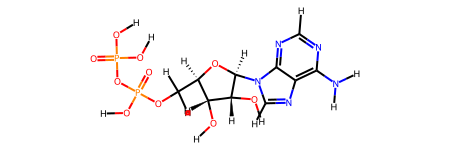

In [ ]:
# Check our molecule from RDKit. Doesn't have rotation, but its neat to see in a Jupyter Notebook for just invoking it
from rdkit.Chem import AllChem, Draw

AllChem.Compute2DCoords(corrected_pose_with_H)
Draw.MolToImage(corrected_pose_with_H)

corrected_pose_with_H

In [ ]:
# Check results
print("Corrected pose SMILES:", Chem.MolToSmiles(corrected_pose_with_H))

supp = Chem.SDMolSupplier(f"{ligand_directory}/{ligand_id}_corrected_pose.sdf")

for mol in supp:
    if mol is not None:
        print(Chem.MolToSmiles(mol))

print("Ideal mol SMILES:", Chem.MolToSmiles(ideal_mol))

u.select_atoms("segid A")

Corrected pose SMILES: [H]O[C@@]1([H])[C@@]([H])(O[H])[C@]([H])(n2c([H])nc3c(N([H])[H])nc([H])nc32)O[C@]1([H])C([H])([H])OP(=O)(O[H])OP(=O)(O[H])O[H]
Nc1ncnc2c1ncn2[C@@H]1O[C@H](CO[P@](=O)(O)OP(=O)(O)O)[C@@H](O)[C@H]1O
Ideal mol SMILES: Nc1ncnc2c1ncn2[C@@H]1O[C@H](CO[P@](=O)(O)OP(=O)(O)O)[C@@H](O)[C@H]1O


<AtomGroup with 3139 atoms>

# Partial Charge for the Ligand

# Creating tautomers (optional)

In [ ]:
from rdkit.Chem.MolStandardize import rdMolStandardize
# Initialize enumerator
tautomer_enumerator = rdMolStandardize.TautomerEnumerator()
# Provide RDKit Mol object to generate.
# We already made this, but you may start from a SMILE string or other source
# Remember, use the structure with implicit hydrogens!
tautomers = tautomer_enumerator.Enumerate(corrected_pose)
# Take the TautomerEnumerationResults object and iterate over to get a list of structures
tautomers_list = [t for t in tautomers]

'''
Note! This may generate duplicate structures,
You may want to cast these Mol objects into SMILES strings, de-duplicate,
then rebuild the Mol objects to map their coordinates back onto the reference structure
'''

# Cast to a set to make unique, then back to a list (as some tautomers can be enumerated again for some structures)
smiles_set_tautomers = set(Chem.MolToSmiles(t) for t in tautomers_list)
tautomer_list_unique = list(smiles_set_tautomers)
# We know the ligand structure does have unique tautomers, this is just a sanity check
assert len(tautomers_list) == len(tautomer_list_unique)

In [ ]:
ligand_tautomers = f"{ligand_directory}/{ligand_id}_tautomers.sdf"
writer = Chem.SDWriter(ligand_tautomers)
for t in tautomers_list:
  writer.write(t)
writer.close()

In [ ]:
for t in tautomer_list_unique:
  print(t)

N=c1nc[nH]c2c1ncn2[C@@H]1O[C@H](COP(=O)(O)OP(=O)(O)O)[C@@H](O)[C@H]1O
Nc1ncnc2c1ncn2[C@@H]1O[C@H](COP(=O)(O)OP(=O)(O)O)[C@@H](O)[C@H]1O
N=c1[nH]cnc2c1ncn2[C@@H]1O[C@H](COP(=O)(O)OP(=O)(O)O)[C@@H](O)[C@H]1O


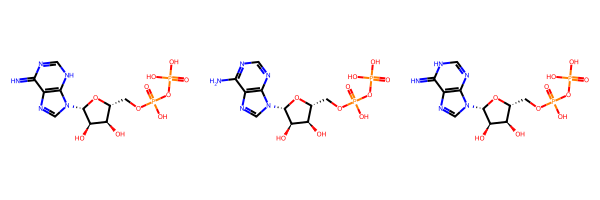

In [ ]:
from rdkit.Chem import Draw
Draw.MolsToGridImage([Chem.MolFromSmiles(t) for t in tautomer_list_unique])

# Scrubber - remove metals, salts, adding charges

In [ ]:
from rdkit import Chem
from scrubber import Scrub

!scrub.py molecular_docking/ligand_structures/ADP_corrected_pose.sdf -o molecular_docking/ligand_structures/ADP.sdf

# Create our PDBQT to keep our hydrogens
ligand_pdbqt_filename = f"{ligand_directory}/{ligand_id}.pdbqt"
os.system(f"obabel {ligand_corrected_pose_file} -O {ligand_pdbqt_filename} -xh")

Scrub completed.
Summary of what happened:
Input molecules supplied: 1
mols processed: 1, skipped by rdkit: 0, failed: 0
nr isomers (tautomers and acid/base conjugates): 3 (avg. 3.000 per mol)
nr conformers:  3 (avg. 1.000 per isomer, 3.000 per mol)


0

In [ ]:
# Voila! The ligand is ready for docking!

## Preparing multiple ligands from SMILES strings

In [ ]:
# Load the SMILES strings into RDKit and write back out an SDF file.

# Default delimiter is tab (\t), so we need to specify ","
smiles_supplier = Chem.SmilesMolSupplier(f"{ligand_directory}/test1.csv", delimiter=",")
mols = []  # Could do this in list comprehension, adding a sanity check
for mol in smiles_supplier:
  print(Chem.MolToSmiles(mol))  # Sanity check that we got the smiles strings and not metadata
  mols.append(mol)

# Write out our molecules
ligands_to_dock_dirty = f"{ligand_directory}/ligands_to_dock_dirty.sdf"
writer = Chem.SDWriter(ligands_to_dock_dirty)
for m in mols:
  writer.write(m)
writer.close()

Brc1cc(N/N=C/c2c[nH]nn2)ccn1
C(=N/Nc1ccncc1)\c1c[nH]nn1
O=C(NCc1c[nH]nn1)c1ccnc(Br)c1
FC(F)(F)c1cc(N/N=C/c2c[nH]nn2)ccn1
CC(C)c1cc(N/N=C/c2c[nH]nn2)ccn1
O=C(NCc1c[nH]nn1)c1ccncc1
O=C(NCc1c[nH]nn1)c1ccnc(C(F)(F)F)c1
CC(C)c1cc(C(=O)NCc2c[nH]nn2)ccn1


[13:23:30] WARNING: no name column found on line 1
[13:23:30] WARNING: no name column found on line 2
[13:23:30] WARNING: no name column found on line 3
[13:23:30] WARNING: no name column found on line 4
[13:23:30] WARNING: no name column found on line 5
[13:23:30] WARNING: no name column found on line 6
[13:23:30] WARNING: no name column found on line 7
[13:23:30] WARNING: no name column found on line 8


In [ ]:
!scrub.py molecular_docking/ligand_structures/ligands_to_dock_dirty.sdf -o molecular_docking/ligand_structures/ligands_to_dock.sdf

Scrub completed.
Summary of what happened:
Input molecules supplied: 8
mols processed: 8, skipped by rdkit: 0, failed: 0
nr isomers (tautomers and acid/base conjugates): 52 (avg. 6.500 per mol)
nr conformers:  52 (avg. 1.000 per isomer, 6.500 per mol)


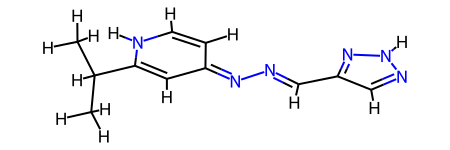

In [ ]:
# Sanity check we got a structure with hydrogens
# RDKit automatically removes hydrogens by default (needed for most of the kit to work)
# But we're explicitly looking for them here, we can just load them and check
supplier = Chem.SDMolSupplier(f"{ligand_directory}/ligands_to_dock.sdf", removeHs=False)
reloaded_ligands = [mol for mol in supplier]
# The last structure will be the same as the last in list comprehension above
reloaded_ligands[-1]

# Visualization tool py3Dmol

In [ ]:
import py3Dmol

# Compare the two ligand models
v = py3Dmol.view()
v.addModel(open(f"{ligand_directory}/{ligand_id}_fromPDB.pdb").read())
v.addModel(open(f"{ligand_corrected_pose_file}").read())
v.addModel(open(f"{ligand_directory}/{ligand_id}_ideal.sdf").read())
#v.setStyle()
v.setStyle({"model":0}, {'stick': {'color': '#0e9674'}})
v.setStyle({"model":1}, {'stick': {'color': '#c46225'}})
v.zoomTo({'model':0})

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [ ]:
# Voila! The ligands are ready for docking!